In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

In [3]:
#Python code to build a database from csv files through sqlite

import csv
import sqlite3
import glob
import os

def do_directory(csvfiles, db):
    for filename in glob.glob(os.path.join(csvfiles, '*.csv')):
        do_file(filename, db)

def do_file(filename, db):
        with open(filename) as f:
            with db:
                data = csv.DictReader(f)
                cols = data.fieldnames
                table=os.path.splitext(os.path.basename(filename))[0]

                sql = 'drop table if exists "{}"'.format(table)
                db.execute(sql)

                sql = 'create table "{table}" ( {cols} )'.format(
                    table=table,
                    cols=','.join('"{}"'.format(col) for col in cols))
                db.execute(sql)

                sql = 'insert into "{table}" values ( {vals} )'.format(
                    table=table,
                    vals=','.join('?' for col in cols))
                db.executemany(sql, (list(map(row.get, cols)) for row in data))

if __name__ == '__main__':
    conn = sqlite3.connect('uber_lyft_data.db')
    do_directory('.', conn)

In [4]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT * FROM cab_rides"
resoverall = c.execute(select_query)
df_cab = pd.DataFrame(resoverall.fetchall())
df_cab.columns = [i[0] for i in c.description]
conn.close()

In [5]:
#df_cab = pd.read_csv('cab_rides.csv')
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5,1,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11,1,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7,1,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26,1,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9,1,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [6]:
df_cab.shape
df_cab = df_cab.convert_objects(convert_numeric=True)

C:\Users\Gaurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [7]:
df_cab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
distance            693071 non-null float64
cab_type            693071 non-null object
time_stamp          693071 non-null int64
destination         693071 non-null object
source              693071 non-null object
price               637976 non-null float64
surge_multiplier    693071 non-null float64
id                  693071 non-null object
product_id          693071 non-null object
name                693071 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [8]:
time_stamp_edit = (df_cab['time_stamp']-(df_cab['time_stamp']%1000))/1000
new_time = pd.to_datetime(time_stamp_edit, unit = 's') - pd.Timedelta(hours=5)

In [9]:
df_cab['dateandtime'] = new_time

In [10]:
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,dateandtime
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 04:30:07
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-26 21:00:23
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-27 20:00:22
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-29 23:53:02
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-28 22:49:20


In [11]:
db_file = 'uber_lyft_data.db'
conn=create_connection(db_file)
c = conn.cursor()
select_query = "SELECT cab_type, count(*) as id FROM cab_rides group by cab_type"
resoverall = c.execute(select_query)
df_cab_type_groupby = pd.DataFrame(resoverall.fetchall())
df_cab_type_groupby.columns = [i[0] for i in c.description]
conn.close()

In [12]:
df_cab_type_groupby

,cab_type,id
0,Lyft,307408
1,Uber,385663


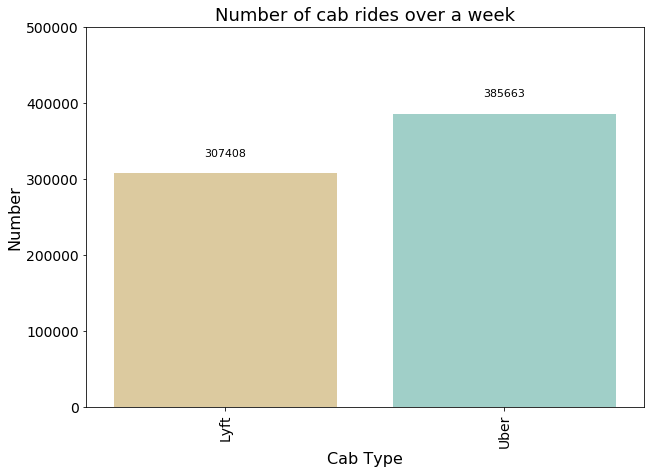

In [13]:
pal = sns.color_palette("BrBG_r", len(df_cab_type_groupby))
plt.figure(figsize=(10,7))
g = sns.barplot(x='cab_type',y='id', data = df_cab_type_groupby,palette=np.array(pal[::-1]))
ax=g
plt.xlabel("Cab Type",fontsize=16)
plt.ylabel("Number",fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Number of cab rides over a week", fontsize=18)

for p in g.patches:
             g.annotate("%i" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,500000)

In [14]:
temp_date_time_series = df_cab.loc[df_cab['id'] == '4bd23055-6827-41c6-b23b-3c491f24e74d' , 'dateandtime']

In [15]:
df_cab['new_date'] = [d.date() for d in df_cab['dateandtime']]
df_cab['new_time'] = [d.time() for d in df_cab['dateandtime']]

In [16]:
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,dateandtime,new_date,new_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 04:30:07,2018-12-16,04:30:07
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-26 21:00:23,2018-11-26,21:00:23
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-27 20:00:22,2018-11-27,20:00:22
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-29 23:53:02,2018-11-29,23:53:02
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-28 22:49:20,2018-11-28,22:49:20


In [17]:
#check for missing values
df_cab.isnull().sum(axis = 0)

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dateandtime             0
new_date                0
new_time                0
dtype: int64

In [18]:
df_price_null = df_cab[df_cab['price'].isnull()]
df_price_null_group = df_price_null.groupby(['cab_type','name'])[['id']].count().reset_index()
df_price_null_group

,cab_type,name,id
0,Uber,Taxi,55095


In [19]:
#We'll drop all the rows with cab_type as "Uber" and name as "Taxi" since the price for these cabs is missing.
df_uber_taxi_index = df_cab[df_cab['name'] == 'Taxi'].index
df_cab.drop(df_uber_taxi_index, inplace = True)
df_cab_dist_price = df_cab[['cab_type','distance','price']]

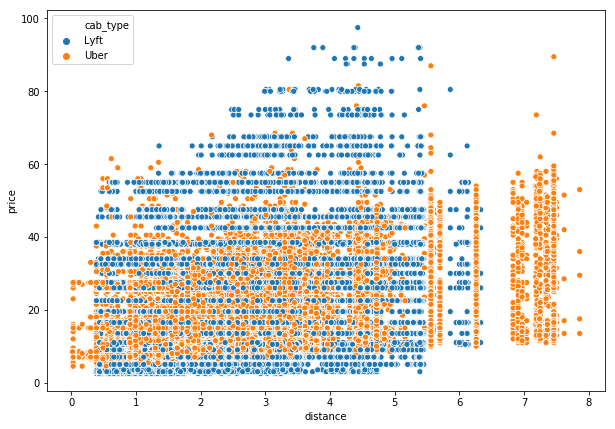

In [20]:
#pal = sns.color_palette("YlOrRd", len(df_cab_dist_price))
plt.figure(figsize=(10,7))
sns.scatterplot(x=df_cab_dist_price.distance,y=df_cab_dist_price.price ,hue = df_cab_dist_price['cab_type'])

In [21]:
#extracted Weekday
df_cab['weekday_number'] = pd.DatetimeIndex(df_cab['new_date']).weekday
lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_cab['weekday_name'] = df_cab['weekday_number'].apply(lambda x: str(lookup[x]))

In [22]:
groupby_weekday = df_cab.groupby(['weekday_name'])[['id']].count().reset_index()
groupby_weekday

,weekday_name,id
0,Friday,83189
1,Monday,126639
2,Saturday,82708
3,Sunday,87149
4,Thursday,82287
5,Tuesday,86099
6,Wednesday,89905


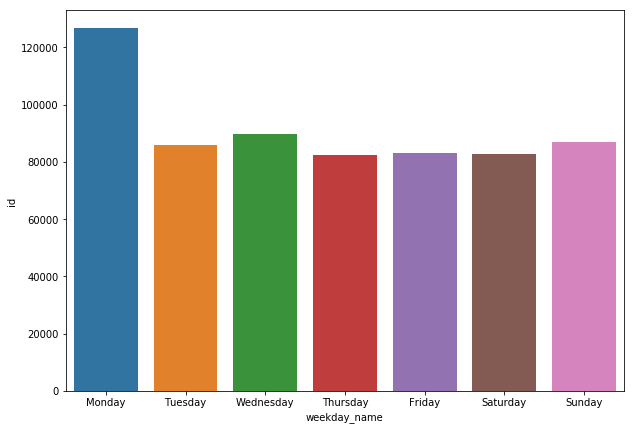

In [24]:
plt.figure(figsize=(10,7))
sns.barplot(x='weekday_name',y='id', data = groupby_weekday,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [25]:
df_cab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637976 entries, 0 to 693070
Data columns (total 15 columns):
distance            637976 non-null float64
cab_type            637976 non-null object
time_stamp          637976 non-null int64
destination         637976 non-null object
source              637976 non-null object
price               637976 non-null float64
surge_multiplier    637976 non-null float64
id                  637976 non-null object
product_id          637976 non-null object
name                637976 non-null object
dateandtime         637976 non-null datetime64[ns]
new_date            637976 non-null object
new_time            637976 non-null object
weekday_number      637976 non-null int64
weekday_name        637976 non-null object
dtypes: datetime64[ns](1), float64(3), int64(2), object(9)
memory usage: 77.9+ MB


In [26]:
df_cab.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,dateandtime,new_date,new_time,weekday_number,weekday_name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 04:30:07,2018-12-16,04:30:07,6,Sunday
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-26 21:00:23,2018-11-26,21:00:23,0,Monday
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-27 20:00:22,2018-11-27,20:00:22,1,Tuesday
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-29 23:53:02,2018-11-29,23:53:02,3,Thursday
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-28 22:49:20,2018-11-28,22:49:20,2,Wednesday


In [27]:
df_uber = df_cab[df_cab['cab_type']=='Uber']
df_uber_group = df_uber.groupby(['name'])[['id']].count().reset_index()
df_lyft = df_cab[df_cab['cab_type']=='Lyft']
df_lyft_group = df_lyft.groupby(['name'])[['id']].count().reset_index()

In [28]:
df_lyft_group

,name,id
0,Lux,51235
1,Lux Black,51235
2,Lux Black XL,51235
3,Lyft,51235
4,Lyft XL,51235
5,Shared,51233


In [29]:
df_uber_group

,name,id
0,Black,55095
1,Black SUV,55096
2,UberPool,55091
3,UberX,55094
4,UberXL,55096
5,WAV,55096


Text(0.5,1,'Lyft prices over the week')

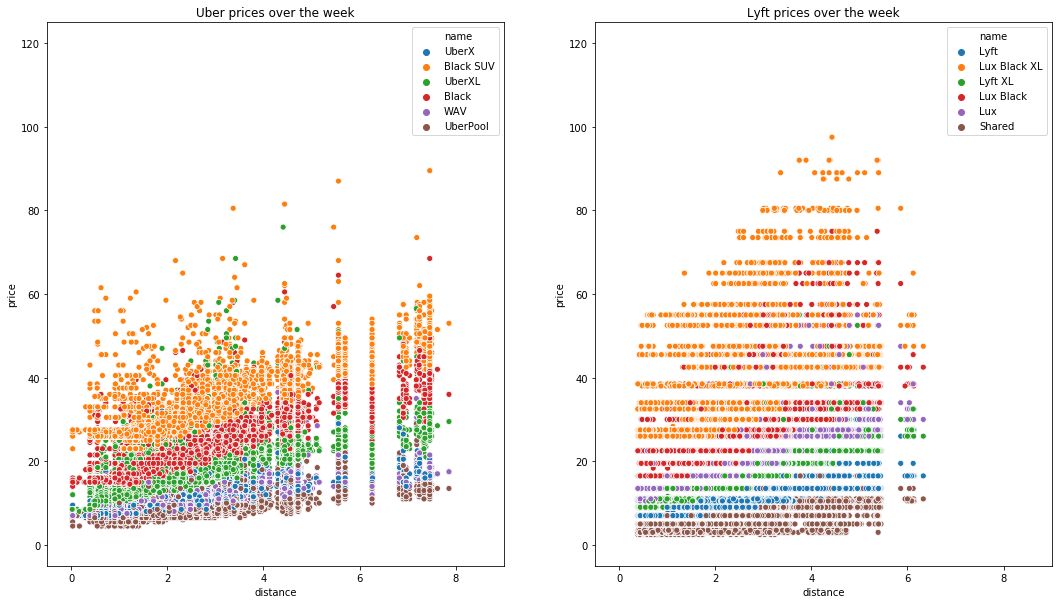

In [39]:
U1=['UberX','Black SUV','UberXL','Black','WAV','UberPool']
L1=['Lyft','Lux Black XL','Lyft XL','Lux Black','Lux','Shared']

plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt1 = sns.scatterplot(x=df_uber.distance,y=df_uber.price ,hue = df_uber['name'], hue_order = U1)
plt.subplot(1,2,2)
plt2 = sns.scatterplot(x=df_lyft.distance,y=df_lyft.price ,hue = df_lyft['name'], hue_order = L1)
plt1.set(ylim=(-5, 125))
plt2.set(ylim=(-5, 125))
plt1.set(xlim=(-0.5, 9))
plt2.set(xlim=(-0.5, 9))
plt1.set_title('Uber prices over the week')
plt2.set_title('Lyft prices over the week')